In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Leitura do texto central

In [2]:
inputFile = "data/HN_posts_year_to_Sep_26_2016.csv"
language = 'english'
df = pd.read_csv(inputFile)
corpus = df['title']

In [3]:
inputFile = "data/BrasCubas-Assis.txt"
language = 'portuguese'
with open(inputFile) as f:
    corpus = f.readlines()
    corpus = [paragraph.rstrip() for paragraph in corpus if paragraph != '\n']

### 2. Pré-processamento do texto

In [4]:
punctranslation = str.maketrans(dict.fromkeys(punctuation))
setStopwords = set(stopwords.words(language))

# Realiza a tokenização e tratamento dos parágrafos do texto
def tokenize(corpus: str) -> list:
    corpusTokenized = []
    for paragraph in corpus:
        paragraph = paragraph.lower()                                       # Tratamento de case-sensitive
        paragraph = paragraph.encode('utf8', 'ignore').decode()             # Eliminação de caracteres fora de UTF-8
        paragraph = paragraph.translate(punctranslation)                    # Eliminação de pontuações
        corpusTokenized.append([token for token in paragraph.split()        # Eliminação de stopwords
                                if token not in setStopwords])
    return corpusTokenized
    
corpusTokenized = tokenize(corpus)

### 3. Contagem de unigramas do texto

In [5]:
unigrams = Counter()
for paragraph in corpusTokenized:
    for token in paragraph:
        unigrams[token] += 1

# Mapeamento de acesso (Token <-> Índice representativo)
token2index = {token: index for index, token in enumerate(unigrams.keys())}
index2token = {index: token for token, index in token2index.items()}

### 4. Contagem de bigramas do texto

In [6]:
# Contador de bigramas, considerando uma determinada janela de contexto (nesse caso, 2
# palavras antes e duas palavras depois)
skipgrams = Counter()
gap = 3

for paragraph in corpusTokenized:
    tokens = [token2index[tok] for tok in paragraph]
    
    # Para cada palavra no parágrafo, realiza a análise dos contextos da vizinhança
    for indexWord, word in enumerate(paragraph):
        indexContextMin = max(0, indexWord - gap)
        indexContextMax = min(len(paragraph)-1, indexWord + gap)

        # Para cada contexto da vizinhança, crie um bigrama com a palavra central
        indexContexts = [index for index in range(indexContextMin, indexContextMax + 1) if index != indexWord]
        for indexContext in indexContexts:
            skipgram = (tokens[indexWord], tokens[indexContext])
            skipgrams[skipgram] += 1

# Exibição dos 10 bigramas mais comuns presentes no texto, considerando a janela de contexto estipulada
mostCommon = [(index2token[skipgram[0][0]], index2token[skipgram[0][1]], skipgram[1]) 
               for skipgram in skipgrams.most_common(10)]
mostCommon

[('alguma', 'coisa', 10),
 ('coisa', 'alguma', 10),
 ('ah', 'brejeiro', 8),
 ('brejeiro', 'ah', 8),
 ('idéia', 'fixa', 7),
 ('fixa', 'idéia', 7),
 ('neve', 'neve', 6),
 ('diminuir', 'diminuir', 6),
 ('mesma', 'coisa', 6),
 ('coisa', 'mesma', 6)]

### 5. Criação da matrix de frequência termo-a-termo

In [7]:
# Mapeamento das entradas da matriz esparça de frequência entre os bigramas do texto
rowsMatrix = []
columnsMatrix = []
dataMatrix = []

for (token1, token2), skipgramCount in skipgrams.items():
    rowsMatrix.append(token1)
    columnsMatrix.append(token2)
    dataMatrix.append(skipgramCount)

wwMatrix = sparse.csr_matrix((dataMatrix, (rowsMatrix, columnsMatrix)))
wwMatrix

<3285x3285 sparse matrix of type '<class 'numpy.int64'>'
	with 32684 stored elements in Compressed Sparse Row format>

### 6. Criação da matriz PPMI

In [8]:
# Número total de bigramas presente na matriz de frequência
numSkipgrams = wwMatrix.sum()

# Mapeamento das entradas da matriz PPMI
rowsIndex = []
columnsIndex = []
ppmiData = []

# Vetor de frequência total de cada palavra em todos os possíveis contextos
sumWords = np.array(wwMatrix.sum(axis=0)).flatten()

# Vetor de frequência total de cada contexto para todas as possíveis palavras
sumContexts = np.array(wwMatrix.sum(axis=1)).flatten()

for (tokenWord, tokenContext), skipgramCount in skipgrams.items():

    # Frequência de determinada palavra em determinado contexto
    # [#(w,c)]
    freqWordContext = skipgramCount

    # Frequência de determinada palavra em todos os contextos possíveis
    # [#(w)]
    freqWord = sumContexts[tokenWord]
    
    # Frequência de determinado contexto para todas as palavras possíveis
    # [#(c)]
    freqContext = sumWords[tokenContext]

    # Probabilidade de ocorrência de determinada palavra em determinado contexto
    # [P(w,c)]
    probWordContext = freqWordContext / numSkipgrams

    # Probabilidade de ocorrência de determinada palavra individualmente
    # [P(w)]
    probWord = freqWord / numSkipgrams

    # Probabilidade de ocorrência de determinado contexto individualmente
    # [P(c)]
    probContext = freqContext / numSkipgrams

    # Cálculo PPMI (Positive Pointwise Mutual Information)
    # [PPMI = max(0, log( P(w,c)/(P(w)P(c)) ))]
    PPMI = max(np.log2(probWordContext / (probWord * probContext)), 0)

    rowsIndex.append(tokenWord)
    columnsIndex.append(tokenContext)
    ppmiData.append(PPMI)

ppmiMatrix = sparse.csr_matrix((ppmiData, (rowsIndex, columnsIndex)))
ppmiMatrix

<3285x3285 sparse matrix of type '<class 'numpy.float64'>'
	with 32684 stored elements in Compressed Sparse Row format>

### 7. Fatoração matricial usando SVD (Singular Value Decomposition)

In [9]:
from scipy.sparse.linalg import svds as SVD

# Dimensão proposta da matriz de valores singulares produzida pelo SVD
# [Hiperparâmetro]
embeddingSize = 50

U, D, V = SVD(ppmiMatrix, embeddingSize)

# Normalização das matrizes de vetores singulares produzidas pelo SVD
Unorm = U / np.sqrt(np.sum(U*U, axis=1, keepdims=True))
Vnorm = V / np.sqrt(np.sum(V*V, axis=1, keepdims=True))

# ???
wordVecs = Unorm

### 8. Visualização de palavras similares por similaridade por cosseno

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Cálculo dos 10 contextos mais similares a dada palavra utilizando a matriz de Word Embedding
def wordsSimilarity(word, matrix, n):
    wordIndex = token2index[word]

    # Resgate do vetor representante de determinada palavra
    if isinstance(matrix, sparse.csr_matrix):
        wordVec = matrix.getrow(wordIndex)
    else:
        wordVec = matrix[wordIndex:wordIndex+1, :]

    # Cálculo da similidade (similaridade de vetores por cosseno)
    similarity = cosine_similarity(matrix, wordVec).flatten()
    sortedIndexes = np.argsort(-similarity)

    # Retorno dos n contextos mais similares a dada palavra
    similarityContextScores = [(index2token[sortedIndex], similarity[sortedIndex]) 
                                for sortedIndex in sortedIndexes[:n+1] 
                                if index2token[sortedIndex] != word]

    return similarityContextScores

def wordSimilarityReport(word, matrix, n=5):
    print(f'\'{word}\'\t Frequência total: {unigrams[word]}', end='\n\t')

    similarityContextScores = wordsSimilarity(word, matrix, n)
    for context, similarity in similarityContextScores:
        print(f'(\'{context}\', {similarity})', end='\t')
    

In [11]:
# Comentar a depender do dataset
# examples = ['spotify', 'learning', 'deep', 'snapchat', 'facebook', 'musk', 'linux', 'safety']
# for word in examples:
#     wordSimilarityReport(word, wordVecs)
#     print('\n'+'---'*20)

### 9. Visualizando as palavras através de um ScatterPlot interativo

In [12]:
def createWordVecsDataFrame(reducedWordVecs, token2index):
    # Criando um dicionário para cada palavra e seu respectivo vetor após redução de dimensionalidade
    dictReducedWordVecs = {}
    for word, index in token2index.items():
        dictReducedWordVecs[word] = reducedWordVecs[index]

    # Instanciando o dataframe a partir do dicionario criado acima
    dfWordVecs = pd.DataFrame.from_dict(
        data = dictReducedWordVecs,
        orient = 'index',
        columns = ['x', 'y']
    )
    dfWordVecs['word'] = dfWordVecs.index
    
    return dfWordVecs

In [15]:
# Configurando a ferramenta interativa com o notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()


def interativePlot(df, title = None, xlabel = None, ylabel = None):
    # Instancia uma ColumnDAtaSource do Bokeh usando o dataframe
    data = ColumnDataSource(df)

    # Cria o plot e configura:
    # título, dimensões e ferramentas interativas
    plot = figure(
        title= title,
        plot_width=800,
        plot_height=800,
        tools=(
            'pan, wheel_zoom, box_zoom,'
            'box_select, reset',
            HoverTool(tooltips = '@word')
            ),
        active_scroll='wheel_zoom',
        x_axis_label = xlabel,
        y_axis_label = ylabel
        )

    # Desenha os circulos representado as palavras
    plot.circle(
        'x',
        'y',
        source=data,
        color='blue',
        line_alpha=0.2,
        fill_alpha=0.1,
        size=10,
        hover_line_color='black'
        )

    # Configuração de outros detalhes visuais
    plot.xaxis.visible = False
    plot.yaxis.visible = False
    plot.grid.grid_line_color = None
    plot.outline_line_color = None


    show(plot);


Loading BokehJS ...

In [16]:
from sklearn.decomposition import PCA

# Realizando redução de dimensão com PCA
pca = PCA(n_components = 2)
reducedWordVecs = pca.fit_transform(wordVecs)
dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
interativePlot(dfWordVecs, title = 'Word Vecs (PCA)')

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE()
reducedWordVecs = tsne.fit_transform(wordVecs)
dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
interativePlot(dfWordVecs, title = 'Word Vecs (TSNE)')

### 10. Visualização a partir de um agrupamento hierárquico das palavras

In [34]:
# Cria um conjunto de palavras considerando as de referência juntamente com as suas n mais similares
def sampleWords(referenceWords, wordVecs, n = 5):
    sample = set()
    for word in referenceWords:
        sample.add(word)
        similarityContextScores = wordsSimilarity(word, wordVecs, n)
        for context, _ in similarityContextScores:
            sample.add(context)
            
    return sample

In [40]:
# Escolhe as palavras que serão usadas como referência para obter uma amostra
referenceWords = [
    'defunto', 'brás', 'romance', 'coimbra', 'flagelos', 'alegria', 'shakespeare', 'homem', 'luxo',
    'filósofo', 'festa', 'olhos', 'ontem', 'guerra', 'ensino'
]

sample = sampleWords(referenceWords, wordVecs)

# Obtem os respectivos Word Embeddings
embeddings = [wordVecs[token2index[word]] for word in sample]

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage
def plotDendogram(words, embeddings, title = None, xlabel = None, ylabel = None, figsize = (25,5)):
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # clustering do tipo aglomerativo, usando o método Farthest Point Algorithm
    # com cosseno como métrica
    link = linkage(embeddings, method = 'complete', metric = 'cosine')
    
    dendrogram(
        link,
        labels = words,
        leaf_rotation=90.,  
        leaf_font_size=10.,  
        orientation='top',
    )
    
    plt.show()
    

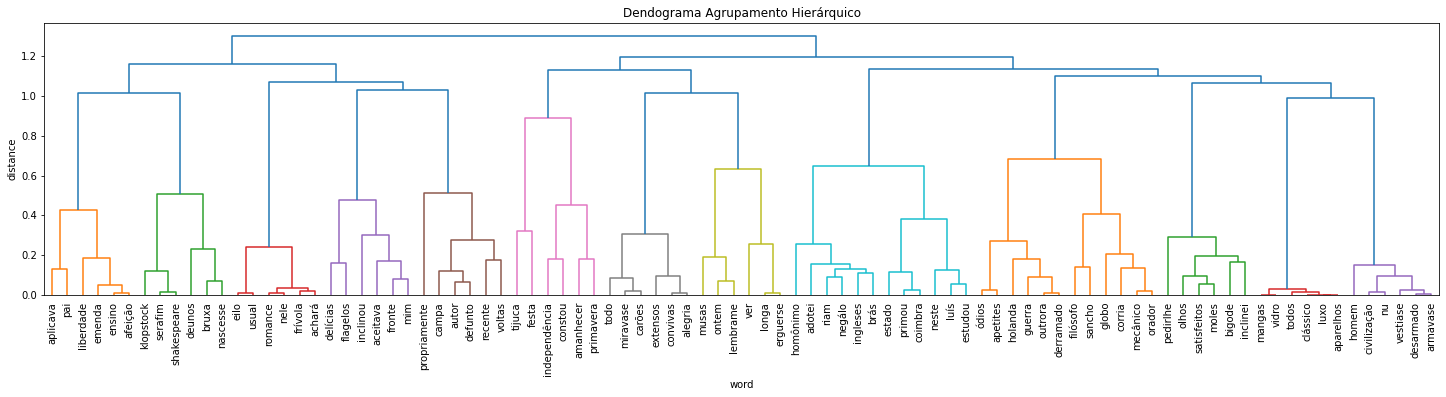

In [45]:
plotDendogram(list(sample), embeddings, title = 'Dendograma Agrupamento Hierárquico', 
              ylabel = 'distance', xlabel = 'word')